In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

In [2]:
df = pd.read_csv(
	"data/household_power_consumption.txt",
	sep=';',
	low_memory=False
)

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


We can see that data has inappropriate format (Dtype). All the column except Date and Time should be float. Computer will not work with strings, we try to avoid this format.

In [6]:
columns = list(df.columns)
columns.remove("Date")
columns.remove("Time")

for column in columns:
	df[column] = pd.to_numeric(df[column], errors="coerce")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


To get away from string columns, we combine Date and Time columns and put them as index

In [8]:
df["full_time"] = pd.to_datetime(df["Date"] + ' ' + df["Time"], dayfirst=True)

df.set_index("full_time", inplace=True)

df.drop(columns=["Date", "Time"], inplace=True)

In [9]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
full_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [10]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [11]:
df.isna().sum(axis=0)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
nan_rows = df.isna().all(axis=1)

nan_rows.sum()

np.int64(25979)

(array([13514., 13695., 13879., 14061., 14245., 14426., 14610., 14791.,
        14975.]),
 [Text(13514.0, 0, '2007-01'),
  Text(13695.0, 0, '2007-07'),
  Text(13879.0, 0, '2008-01'),
  Text(14061.0, 0, '2008-07'),
  Text(14245.0, 0, '2009-01'),
  Text(14426.0, 0, '2009-07'),
  Text(14610.0, 0, '2010-01'),
  Text(14791.0, 0, '2010-07'),
  Text(14975.0, 0, '2011-01')])

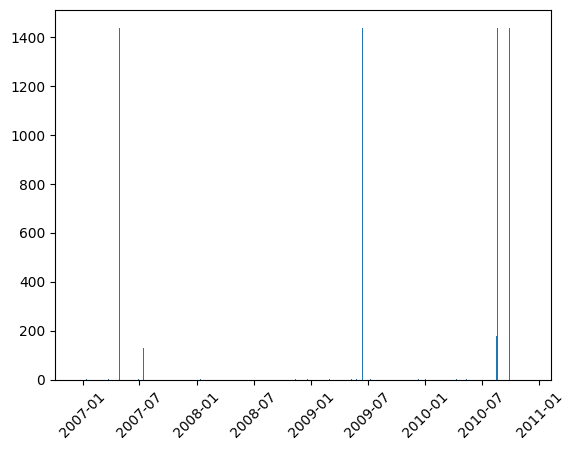

In [13]:
nan_rows = nan_rows.resample('D').sum()

dates = nan_rows.index
values = nan_rows.values

plt.bar(dates, values)
plt.xticks(rotation=45)

We have to fill these NaN values. We can do it by replacing them with median or mean of the column. I think median is more appropriate, because electricity consumptions distribution is very skewed. Mean is very vulnurable to outliers or skewed distributions

In [14]:
interval = 21
interval_means = df.rolling(window=interval, center=True, min_periods=int(interval / 2)).mean()

df = df.fillna(interval_means)

In [15]:
df = df.dropna(axis=0)

In [16]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

array([[<Axes: title={'center': 'Global_active_power'}>,
        <Axes: title={'center': 'Global_reactive_power'}>,
        <Axes: title={'center': 'Voltage'}>],
       [<Axes: title={'center': 'Global_intensity'}>,
        <Axes: title={'center': 'Sub_metering_1'}>,
        <Axes: title={'center': 'Sub_metering_2'}>],
       [<Axes: title={'center': 'Sub_metering_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

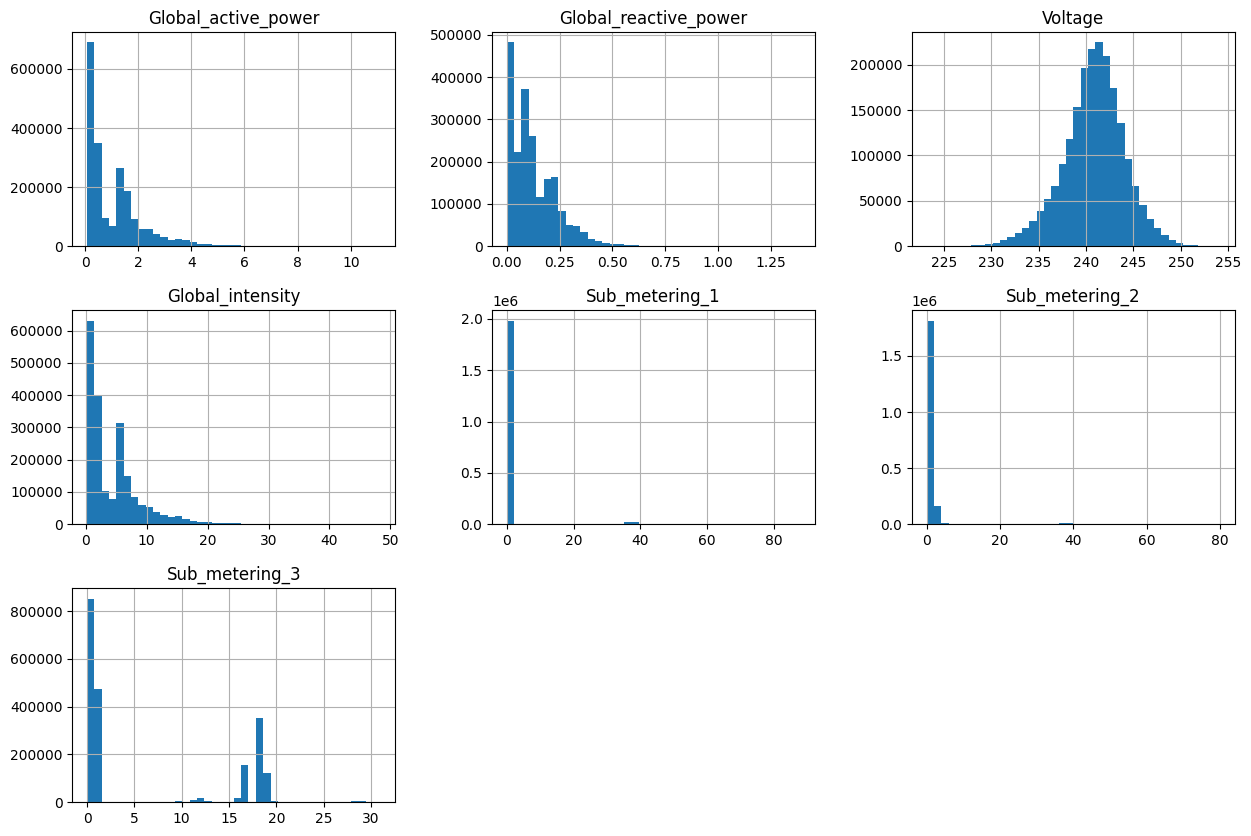

In [17]:
df.hist(figsize=(15, 10), bins=40)

from these graphs we can say that our data has a lot of outliers. Normal distribution has only Voltage feature.

<Axes: >

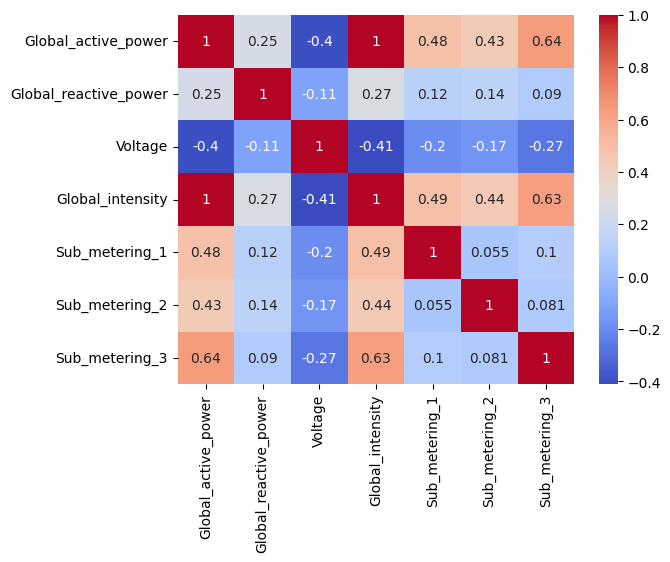

In [18]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Standard train_test_split would be a bad option for us, because we work with sequential data. We must cut the data chronologically;

In [19]:
print(df.index[0])
print(df.index[len(df) - 1])

2006-12-16 17:24:00
2010-11-26 21:02:00


In [20]:
split_id = pd.to_datetime("2009-12-30 00:00:00", dayfirst=True)

X = df.drop(columns=["Global_active_power"])
y = df["Global_active_power"]

X_train = X.loc[:split_id, :]
X_test = X.loc[split_id:, :]

y_train = y.loc[:split_id]
y_test = y.loc[split_id:]

C:\Users\zokse\AppData\Local\Temp\ipykernel_17432\819709768.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  split_id = pd.to_datetime("2009-12-30 00:00:00", dayfirst=True)


In [21]:
print(X_train.shape)
print(y_train.shape)

(1589097, 6)
(1589097,)


In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
VAL_SPLIT = 0.1
val_split_id = int(len(X_train) * (1 - VAL_SPLIT))

X_tr = X_train[:val_split_id]
X_val = X_train[val_split_id:]

y_tr = y_train.values[:val_split_id]
y_val = y_train.values[val_split_id:]

In [24]:
SEQ_LEN = 60
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

An LSTM cannot learn from single time steps. It needs a sequence of past observations to predict a future value so we convert time-series into sliding windows

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
X_tr_seq, y_tr_seq = create_sequences(X_tr, y_tr, SEQ_LEN)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, SEQ_LEN)

In [27]:
X_tr_t = torch.tensor(X_tr_seq, dtype=torch.float32).to(device)
y_tr_t = torch.tensor(y_tr_seq, dtype=torch.float32).unsqueeze(1).to(device)

X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1).to(device)

X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1).to(device)

In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [29]:
param_grid = {
    "hidden_size": [32, 64, 128],
    "num_layers": [1, 2, 3],
    "learning_rate": [1e-3, 5e-4, 1e-4],
    "batch_size": [32, 64]
}

N_TRIALS = 6 # number of hyperparameter tuning times
EPOCHS_TUNE = 5 # number of epochs for hyperparameter tuning

In [30]:
def train_and_validate(params):
    model = LSTM(
        input_size=X_tr_seq.shape[2],
        hidden_size=params["hidden_size"],
        output_size=1,
        num_layers=params["num_layers"]
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.MSELoss()

    for _ in range(EPOCHS_TUNE):
        model.train()
        perm = torch.randperm(X_tr_t.size(0))

        for i in range(0, X_tr_t.size(0), params["batch_size"]):
            idx = perm[i:i+params["batch_size"]]
            bx, by = X_tr_t[idx], y_tr_t[idx]

            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, X_val_t.size(0), params["batch_size"]):
            bx, by = X_val_t[i:i+params["batch_size"]], y_val_t[i:i+params["batch_size"]]
            val_loss += criterion(model(bx), by).item() * bx.size(0)

    return val_loss / X_val_t.size(0)

As a loss function we use Mean Squared Error (MSE) because it is regression task. Also it penalizes larger errors more strongly.

In [31]:
best_loss = float("inf")
best_params = None

for trial in range(N_TRIALS):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"\nTrial {trial+1}/{N_TRIALS} | {params}")
    loss = train_and_validate(params)
    print(f"Validation MSE: {loss:.6f}")

    if loss < best_loss:
        best_loss = loss
        best_params = params

print("\nBest hyperparameters:", best_params)


Trial 1/6 | {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 64}
Validation MSE: 0.062823

Trial 2/6 | {'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 32}
Validation MSE: 0.060001

Trial 3/6 | {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.0005, 'batch_size': 64}
Validation MSE: 0.054502

Trial 4/6 | {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.0005, 'batch_size': 64}
Validation MSE: 0.053246

Trial 5/6 | {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32}
Validation MSE: 0.052778

Trial 6/6 | {'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 32}
Validation MSE: 0.059970

Best hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32}


Random search was used for hyperparameter tuning due to its efficiency in exploring high-dimensional search spaces and its suitability for computationally expensive deep learning models. Unlike grid search, random search evaluates a diverse set of configurations while requiring fewer training runs.
The tuned hyperparameters included the number of LSTM hidden units, number of recurrent layers, learning rate, and batch size. Model performance was evaluated using validation Mean Squared Error, and the best-performing configuration was selected for final training.
This approach provides a good trade-off between computational cost and model performance and is well-suited for time-series forecasting tasks. And now we will train our model with the best hyperparameters that we found.

In [32]:
model = LSTM(
    input_size=X_tr_seq.shape[2],
    hidden_size=best_params["hidden_size"],
    output_size=1,
    num_layers=best_params["num_layers"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss()

EPOCHS = 10
BATCH_SIZE = best_params["batch_size"]

In [33]:
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    start = time.time()
    total_loss = 0
    perm = torch.randperm(X_tr_t.size(0))

    for i in range(0, X_tr_t.size(0), BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        bx, by = X_tr_t[idx], y_tr_t[idx]

        optimizer.zero_grad()
        loss = criterion(model(bx), by)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * bx.size(0)

        progress = min(i+BATCH_SIZE, X_tr_t.size(0)) / X_tr_t.size(0)
        eta = (time.time() - start) * (1 - progress) / progress
        print(f"\rEpoch {epoch+1}/{EPOCHS} | ETA: {eta:.1f}s", end="")

    train_loss = total_loss / X_tr_t.size(0)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, X_val_t.size(0), BATCH_SIZE):
            bx, by = X_val_t[i:i+BATCH_SIZE], y_val_t[i:i+BATCH_SIZE]
            val_loss += criterion(model(bx), by).item() * bx.size(0)

    val_loss /= X_val_t.size(0)
    val_losses.append(val_loss)

    print(f" | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

Epoch 1/10 | ETA: 0.0s | Train: 0.0743 | Val: 0.0621
Epoch 2/10 | ETA: 0.0s | Train: 0.0610 | Val: 0.0561
Epoch 3/10 | ETA: 0.0s | Train: 0.0575 | Val: 0.0538
Epoch 4/10 | ETA: 0.0s | Train: 0.0552 | Val: 0.0536
Epoch 5/10 | ETA: 0.0s | Train: 0.0539 | Val: 0.0522
Epoch 6/10 | ETA: 0.0s | Train: 0.0530 | Val: 0.0519
Epoch 7/10 | ETA: 0.0s | Train: 0.0523 | Val: 0.0516
Epoch 8/10 | ETA: 0.0s | Train: 0.0516 | Val: 0.0511
Epoch 9/10 | ETA: 0.0s | Train: 0.0510 | Val: 0.0512
Epoch 10/10 | ETA: 0.0s | Train: 0.0506 | Val: 0.0504


In [34]:
model.eval()
preds = []

with torch.no_grad():
    for i in range(0, X_test_t.size(0), 512):
        preds.append(model(X_test_t[i:i+512]).cpu())

y_pred = torch.cat(preds).numpy()

In [35]:
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f"\nRMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 0.2014
MAE: 0.0900
R²: 0.9538


The coefficient of determination (R²) measures how well the regression model explains the variability of the target variable. It represents the proportion of variance in the true values that is captured by the model’s predictions. An R² value of **0.95** indicates that approximately **95.5% of the variability** in global active power consumption is explained by the LSTM model. This suggests that the model successfully captures the underlying temporal patterns and relationships present in the data. R² is particularly useful in regression tasks because it provides a scale-independent measure of model performance and allows direct comparison with baseline models, such as predicting the mean value.
The high R² score confirms that the proposed LSTM model generalizes well and explains most of the variance in household power consumption.

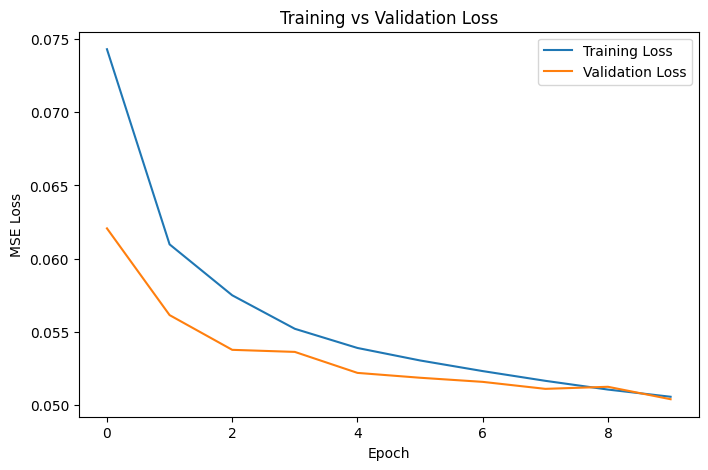

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

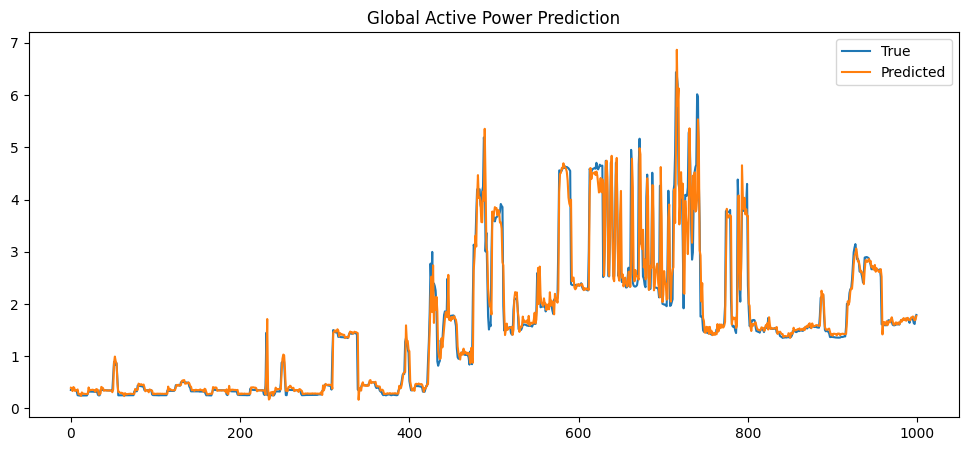

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq[:1000], label="True")
plt.plot(y_pred[:1000], label="Predicted")
plt.legend()
plt.title("Global Active Power Prediction")
plt.show()